## https://www.cnblogs.com/wyh1993/p/6703135.html

## 制作

In [43]:
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
file_path='F://Tensorflow//flower_photos//'
cwd='F://Tensorflow//record//'
classes={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4}
beat_num=128
num=0
record=0
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


writer=tf.python_io.TFRecordWriter(cwd+'flower.tfrecords-'+str(record))
for index,name in enumerate(classes):
    class_path=file_path+name+'\\'
    for img_name in os.listdir(class_path):
        num=num+1
        if(num>beat_num):
            num=1
            record=record+1
            writer=tf.python_io.TFRecordWriter(cwd+'flower.tfrecords-'+str(record))
        img_path=class_path+img_name
        img=Image.open(img_path)
        img=img.resize((256,256))
        img_raw=img.tobytes()
        example=tf.train.Example(features=tf.train.Features(feature={
            'img_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
            'label':tf.train.Feature(int64_list=tf.train.Int64List(value=[index]))
        }))
        writer.write(example.SerializeToString())
writer.close()

## 读取

In [1]:
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
record_path='F:\\Tensorflow\\record\\'
data_path=record_path+'flower.tfrecords-*'
data_paths=tf.gfile.Glob(data_path)
def read_and_decode(data_paths):
    filename_queue=tf.train.string_input_producer(data_paths,shuffle=False)#生成一个queue队列
    reader=tf.TFRecordReader()
    _,serialized_example=reader.read(filename_queue)#返回文件名和文件
    features=tf.parse_single_example(
        serialized_example,
        features={
            'label':tf.FixedLenFeature([],tf.int64),
            'img_raw':tf.FixedLenFeature([],tf.string)
        }
    )
    img=tf.decode_raw(features['img_raw'],tf.uint8)
    img=tf.reshape(img,[256,256,3])
    #img = tf.image.per_image_standardization(img) 
    label=tf.cast(features['label'],tf.int32)
    return img,label

In [2]:
images,labels=read_and_decode(data_paths)

In [3]:
images

<tf.Tensor 'Reshape:0' shape=(256, 256, 3) dtype=uint8>

In [4]:
type(images)

tensorflow.python.framework.ops.Tensor

In [5]:
labels

<tf.Tensor 'Cast:0' shape=() dtype=int32>

## 解析出来

In [7]:
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
cwd='F:\\Tensorflow\\jiexi\\'
X_train=[]
Y_train=[]
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    coord=tf.train.Coordinator()
    threads=tf.train.start_queue_runners(sess=sess,coord=coord)
    for i in range(6444):
        example,l=sess.run([images,labels])
        example=np.array(example)
        img=Image.fromarray(example,'RGB')
        l=np.array(l)
        X_train.append(example)
        Y_train.append(l)
        '''
        if(l==0):
            path=cwd+'daisy'+'\\'
            img.save(path+'daisy'+'_label_'+str(l)+'.jpg')
        if(l==1):
            path=cwd+'dandelion'+'\\'
            img.save(path+'dandelion'+'_label_'+str(l)+'.jpg')
        if(l==2):
            path=cwd+'roses'+'\\'
            img.save(path+'roses'+'_label_'+str(l)+'.jpg')
        if(l==3):
            path=cwd+'sunflowers'+'\\'
            img.save(path+'sunflowers'+'_label_'+str(l)+'.jpg')
        if(l==4):
            path=cwd+'tulips'+'\\'
            img.save(path+'tulips'+'_label_'+str(l)+'.jpg')
        
        
        '''
        
        #print(l)
    coord.request_stop()
    coord.join(threads)

In [8]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)

In [9]:
X_train.shape

(6444, 256, 256, 3)

In [10]:
Y_train.shape

(6444,)

In [11]:
Y_train[6443]

4

In [12]:
type(Y_train[6443])

numpy.int32

0


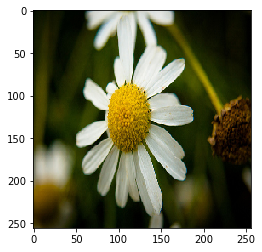

In [13]:
#检查标签是否正确
i=10
print(Y_train[i])
plt.imshow(X_train[i])
plt.show()

## 生成batch，下面证明了图片和标签是一一对应的

In [14]:
batch_size=64
capacity=100+3*batch_size
image_batch,label_batch=tf.train.shuffle_batch([images,labels],batch_size,capacity,min_after_dequeue=30)

In [15]:
len(X_train)
int(len(X_train)/batch_size)

100

In [16]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    coord=tf.train.Coordinator()
    threads=tf.train.start_queue_runners(sess,coord)
    m=int(len(X_train)/batch_size)
    for i in range(m+1):
        cur_X_train,cur_Y_train=sess.run([image_batch,label_batch])
    coord.request_stop()
    coord.join(threads)

In [17]:
cur_X_train=cur_X_train/255.0
cur_Y_train=cur_Y_train.reshape(64,1)

In [18]:
cur_Y_train=np.eye(5)[cur_Y_train.reshape(-1)]

In [19]:
cur_Y_train.shape

(64, 5)

In [20]:
cur_Y_train[0]

array([ 0.,  0.,  0.,  0.,  1.])

[ 0.  0.  0.  0.  1.]


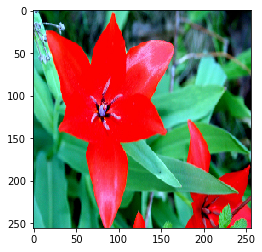

In [21]:
#检查batch标签跟图片是否一致是否正确
i=63
print(cur_Y_train[i])
plt.imshow(cur_X_train[i])
plt.show()

In [22]:
#检查batch标签跟图片是否一致是否正确,输出到文件夹查看结果
from PIL import Image
bao='F:/Tensorflow/batch/'
for i in range(len(cur_X_train)):
    img=Image.fromarray(cur_X_train[i],'RGB')
    img.save(bao+str(i)+'_label_'+str(int(cur_Y_train[i]))+'.jpg')

In [26]:
#batch数据写到文件夹，分类
'''

测试成功！每个batch的图片和类别一一对应
测试成功！每个batch的图片和类别一一对应
测试成功！每个batch的图片和类别一一对应
测试成功！每个batch的图片和类别一一对应

'''
cwd='F:\\Tensorflow\\jiexi\\'
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    coord=tf.train.Coordinator()
    threads=tf.train.start_queue_runners(sess,coord)
    m=int(len(X_train)/batch_size)
    for i in range(m+1):
        cur_X_train,cur_Y_train=sess.run([image_batch,label_batch])
        for j in range(len(cur_X_train)):
            img=Image.fromarray(cur_X_train[j],'RGB')
            if(cur_Y_train[j]==0):
                path=cwd+'daisy'+'\\'
                img.save(path+'daisy'+'_batch_'+str(i)+'_第_'+str(j)+'_label_'+str(cur_Y_train[j])+'.jpg')
            if(cur_Y_train[j]==1):
                path=cwd+'dandelion'+'\\'
                img.save(path+'dandelion'+'batch_'+str(i)+'_第_'+str(j)+'_label_'+str(cur_Y_train[j])+'.jpg')
            if(cur_Y_train[j]==2):
                path=cwd+'roses'+'\\'
                img.save(path+'roses'+'batch_'+str(i)+'_第_'+str(j)+'_label_'+str(cur_Y_train[j])+'.jpg')
            if(cur_Y_train[j]==3):
                path=cwd+'sunflowers'+'\\'
                img.save(path+'sunflowers'+'batch_'+str(i)+'_第_'+str(j)+'_label_'+str(cur_Y_train[j])+'.jpg')
            if(cur_Y_train[j]==4):
                path=cwd+'tulips'+'\\'
                img.save(path+'tulips'+'batch_'+str(i)+'_第_'+str(j)+'_label_'+str(cur_Y_train[j])+'.jpg')
            
    coord.request_stop()
    coord.join(threads)

## 数据准备好了，接下来就是迁

### http://blog.csdn.net/ustbfym/article/details/78201575

### 第一步，读取加载已经训练好的模型

In [22]:
#http://www.36dsj.com/archives/76573
import glob
import os.path
import random
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile
BOTTLENECK_TENSOR_NAME='pool_3/_reshape:0'
JPEG_DATA_TENSOR_NAME='DecodeJpeg/contents:0'
#读取已经训练好的模型
MODEL_DIR='F:/Tensorflow/mo/'
MODEL_FILE='tensorflow_inception_graph.pb'

#加载图上的节点
with gfile.FastGFile(os.path.join(MODEL_DIR,MODEL_FILE),'rb') as f:
    graph_def=tf.GraphDef()
    graph_def.ParseFromString(f.read())
bottleneck_tensor, jpeg_data_tensor = tf.import_graph_def(graph_def, return_elements=[BOTTLENECK_TENSOR_NAME, JPEG_DATA_TENSOR_NAME])
    

In [23]:
bottleneck_tensor

<tf.Tensor 'import/pool_3/_reshape:0' shape=(1, 2048) dtype=float32>

In [33]:
jpeg_data_tensor

<tf.Tensor 'import/DecodeJpeg/contents:0' shape=() dtype=string>

In [82]:

#输入层，有原来的模型输出层feed
bottleneck_input=tf.placeholder(tf.float32,[None,BOTTLENECK_TENSOR_NAME],name='BottleneckInputPlaceholder')
ground_truth_input=tf.placeholder(tf.float32,[None,n_class],name='GroundTruthInput')

#全连接层
with  tf.name_scope('final_train_ops'):
    Weights=tf.Variable(tf.truncated_normal([BOTTLENECK_TENSOR_NAME,n_class],stddev=0.001))
    biases=tf.Variable(tf.zeros([n_class]))
    logits=tf.matmul(bottleneck_input,Weights)+biases
    final_tensor=tf.nn.softmax(logits)

#交叉熵损失函数
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=ground_truth_input))

#优化算法的选择
train_step=tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)


correct_prediction=tf.equal(tf.argmax(final_tensor,1),tf.argmax(ground_truth_input,1))
evaluation_step=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

#将数据进行归一化和将输出构造成向量的形式
X_train=X_train/255.0
Y_train=Y_train.reshape(64,1)
Y_train=np.eye(5)[Y_train.reshape(-1)]

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    coord=tf.train.Coordinator()
    threads=tf.train.start_queue_runners(sess,coord)
    m=int(len(X_train)/batch_size)
    for epho in range(2):
        for i in range(m+1):
            cur_X_train,cur_Y_train=sess.run([image_batch,label_batch])
            evaluation,loss=sess.run([evaluation_step,cross_entropy],feed_dict={bottleneck_input:cur_X_train,ground_truth_input:cur_Y_train})
        print("损失值："+str(loss)+"正确率："+str(evaluation))
    print("训练结束！")
    
    
#2017.12.5：错误原因,代码要先经过模型，将输出的特征向量作为输入才行。
#https://www.cnblogs.com/hellcat/p/6909269.html

ValueError: Error converting shape to a TensorShape: invalid literal for int() with base 10: 'pool_3/_reshape:0'.